In [15]:
import pygsheets
import os
import pandas as pd
import numpy as np
from spotipy import Spotify
from tqdm import tqdm
import seaborn as sns
import json

In [2]:
credentials = SpotifyClientCredentials(
        client_id=os.environ["SPOTIFY_CLIENT_ID"],
        client_secret=os.environ["SPOTIFY_CLIENT_SECRET"])
sp = Spotify(client_credentials_manager=credentials)

In [3]:
PLAYLIST_LINK = "4Dg0J0ICj9kKTGDyFu0Cv4"

In [4]:
def write_tracks(text_file, tracks):
    with open(text_file, 'a') as file_out:
        while True:
            for item in tracks['items']:
                if 'track' in item:
                    track = item['track']
                else:
                    track = item
                try:
                    track_url = track['external_urls']['spotify']
                    file_out.write(track_url + '\n')
                except KeyError:
                    print(u'Skipping track {0} by {1} (local only?)'.format(
                            track['name'], track['artists'][0]['name']))
            # 1 page = 50 results
            # check if there are more pages
            if tracks['next']:
                tracks = sp.next(tracks)
            else:
                break

In [5]:
def write_playlist(username, playlist_id):
    results = sp.playlist(playlist_id,
                                    fields='tracks,next,name')
    text_file = u'{0}.txt'.format(results['name'], ok='-_()[]{}')
    print(u'Writing {0} tracks to {1}'.format(
            results['tracks']['total'], text_file))
    tracks = results['tracks']
    write_tracks(text_file, tracks)

In [6]:
write_playlist('*', PLAYLIST_LINK)

Writing 1322 tracks to The Longest Mixtape: 1000+ Songs For You.txt


In [7]:
!mv The\ Longest\ Mixtape\:\ 1000+\ Songs\ For\ You.txt track_links.txt

In [8]:
with open("track_links.txt") as f:
    spotify_links = f.read().split('\n')
spotify_links.pop(-1)

''

In [9]:
spotify_links[0]

'https://open.spotify.com/track/74usZNReO4g4j5aZ0yAmBw'

In [10]:
spotify_ids = list(map(lambda x: x[len('https://open.spotify.com/track/'):], spotify_links))

In [11]:
spotify_ids[:10]

['74usZNReO4g4j5aZ0yAmBw',
 '0UxMM0hR3o3hu77FkZWdvQ',
 '0PbrN3yxhpjx01gZihUjXA',
 '261oqGIHQWXeBWoLNsnMDm',
 '5ADkHBTfjff1AbgU1ObeDD',
 '1IzhgTb9MmDmTFaKqwR9E2',
 '3iEbpvvr4Y8F7sQshQY1pS',
 '4CdIElRxsKNHa5WEwAHpgA',
 '5UHNN2ftt5AQFQ0I7xPGta',
 '4Ne7tzHOOIPmGGKIupp6xv']

In [12]:
track_meta_data = []
track_audio_features = []
for track_id in tqdm(spotify_ids):
    track_meta_data.append(sp.track(track_id))
    track_audio_features.append(sp.audio_features(track_id)[0])

100%|███████████████████████████████████████████████████████████████████| 1322/1322 [05:35<00:00,  3.95it/s]


In [16]:
with open("control-track-meta-data.json", 'w') as f:
    json.dump(track_meta_data, f, indent=4)

In [17]:
with open("control-track-audio-features.json", 'w') as f:
    json.dump(track_audio_features, f, indent=4)

# Load Data

In [27]:
with open("track-meta-data.json") as f:
    track_meta_data = json.load(f)

True

In [ ]:
with open("track-audio-features.json") as f:
    track_audio_features = json.load(f)

True

In [18]:
track_audio_features[0].keys()

dict_keys(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature'])

In [19]:
track_meta_data[0].keys()

dict_keys(['album', 'artists', 'available_markets', 'disc_number', 'duration_ms', 'explicit', 'external_ids', 'external_urls', 'href', 'id', 'is_local', 'name', 'popularity', 'preview_url', 'track_number', 'type', 'uri'])

In [20]:
def get_feature(feature_name):
    return list(map(lambda x: x[feature_name], track_audio_features))

In [21]:
def get_meta_data(feature_name):
    return list(map(lambda x: x[feature_name], track_meta_data))

In [22]:
feature_data = {}
for feature in track_audio_features[0].keys():
    feature_data[feature] = get_feature(feature)

In [23]:
meta_data = {}
for feature in track_meta_data[0].keys():
    meta_data[feature] = get_meta_data(feature)

<AxesSubplot:>

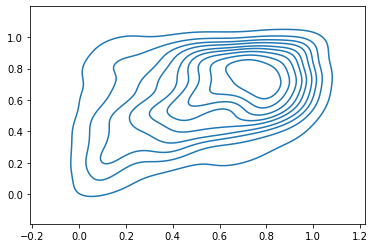

In [52]:
sns.kdeplot(x=feature_data["valence"], y=feature_data["energy"])

In [26]:
sns.colors

<module 'seaborn.colors' from '/home/snehal/miniconda3/lib/python3.8/site-packages/seaborn/colors/__init__.py'>

<AxesSubplot:ylabel='Count'>

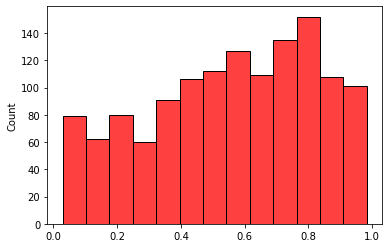

In [27]:
sns.histplot(feature_data["valence"], color='r')

<AxesSubplot:ylabel='Count'>

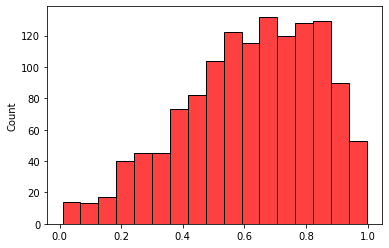

In [28]:
sns.histplot(feature_data["energy"], color='r')

Text(0.5, 1.0, 'Speechiness')

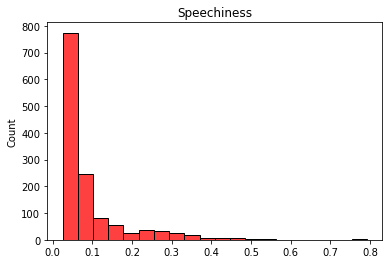

In [31]:
sns.histplot(feature_data["speechiness"], bins=20, color='r').set_title("Speechiness")

Speechiness: “Speechiness detects the presence of spoken words in a track”. If the speechiness of a song is above 0.66, it is probably made of spoken words, a score between 0.33 and 0.66 is a song that may contain both music and words, and a score below 0.33 means the song does not have any speech.

https://towardsdatascience.com/is-my-spotify-music-boring-an-analysis-involving-music-data-and-machine-learning-47550ae931de

Text(0.5, 1.0, 'Instrumentalness')

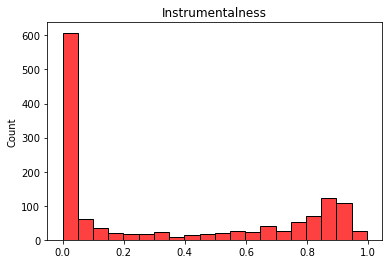

In [32]:
sns.histplot(feature_data["instrumentalness"], bins=20, color='r').set_title("Instrumentalness")

Text(0.5, 1.0, 'Acousticness')

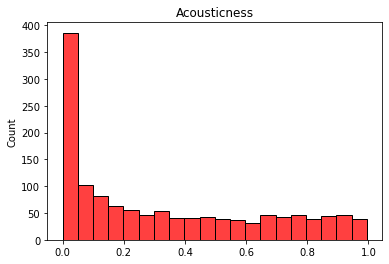

In [35]:
sns.histplot(feature_data["acousticness"], bins=20, color='r').set_title("Acousticness")

<AxesSubplot:>

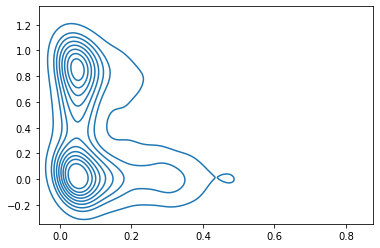

In [57]:
sns.kdeplot(x=feature_data["speechiness"], y=feature_data["instrumentalness"])

<AxesSubplot:ylabel='Count'>

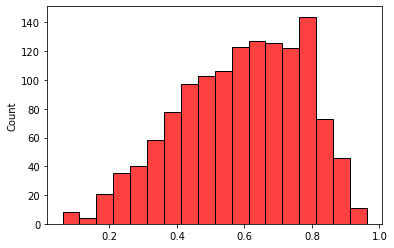

In [36]:
sns.histplot(feature_data["danceability"], color='r')

<AxesSubplot:ylabel='Count'>

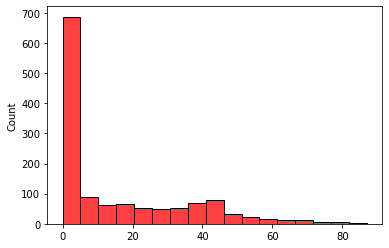

In [37]:
sns.histplot(meta_data["popularity"], color='r')

(0.0, 5000000.0)

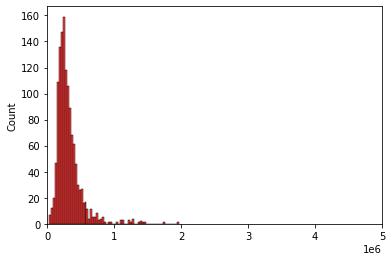

In [41]:
sns.histplot(meta_data["duration_ms"], color='r').set_xlim(0, 5 * 1e6)

<AxesSubplot:ylabel='Count'>

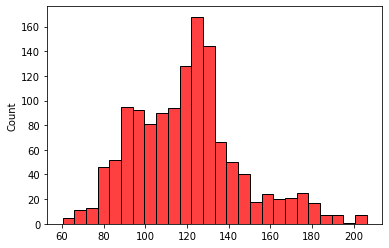

In [42]:
sns.histplot(feature_data["tempo"], color='r')

<AxesSubplot:ylabel='Count'>

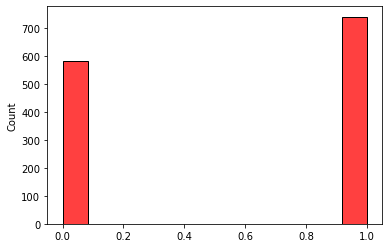

In [43]:
sns.histplot(feature_data["mode"], color='r')

<AxesSubplot:>

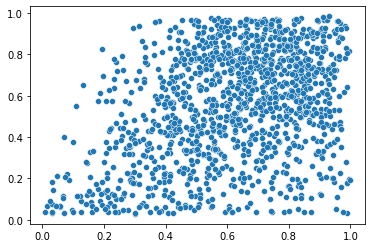

In [62]:
sns.scatterplot(x=feature_data["energy"], y=feature_data["valence"])

# Audio Analysis

In [182]:
test_track_id = spotify_ids[0]

In [183]:
test_track_id

'0QZ5yyl6B6utIWkxeBDxQN'

In [186]:
analysis_features = sp.audio_analysis(test_track_id)

In [188]:
analysis_features.keys()

dict_keys(['meta', 'track', 'bars', 'beats', 'sections', 'segments', 'tatums'])

In [190]:
analysis_features["meta"]

{'analyzer_version': '4.0.0',
 'platform': 'Linux',
 'detailed_status': 'OK',
 'status_code': 0,
 'timestamp': 1571894371,
 'analysis_time': 5.50087,
 'input_process': 'libvorbisfile L+R 44100->22050'}

# Sample Exploration

In [114]:
list(zip(feature_data['speechiness'], meta_data['name''']))[:50]

[(0.035, 'Time in a Bottle'),
 (0.0414, 'Wish You Were Here'),
 (0.0378, 'The Night We Met'),
 (0.038, 'Mystery of Love'),
 (0.0261, 'Cancer'),
 (0.031, 'Transatlanticism'),
 (0.0318, 'Landslide'),
 (0.029, 'Lazarus'),
 (0.0404, 'Over the Rainbow'),
 (0.0418, "Cat's in the Cradle"),
 (0.0337, 'Running Up That Hill'),
 (0.037, 'Fast Car'),
 (0.0365, 'Father And Son'),
 (0.0351, 'Wind Of Change'),
 (0.0568, 'Skinny Love'),
 (0.0333, 'Breathe Me'),
 (0.0275, 'Fade Into You'),
 (0.0446, 'Sweden'),
 (0.0412, 'Casimir Pulaski Day'),
 (0.0456, 'River'),
 (0.0243, 'The Scientist'),
 (0.0238, 'My December'),
 (0.0421, 'I Will Follow You into the Dark'),
 (0.0366, 'White Ferrari'),
 (0.0314, 'Father and Daughter'),
 (0.0326, 'Time To Say Goodbye'),
 (0.0386, 'Learning to Fly'),
 (0.173, 'Good News'),
 (0.0339, 'I Miss You'),
 (0.0257, 'Tears in Heaven'),
 (0.0626, 'The Wreck of the Edmund Fitzgerald'),
 (0.029, 'Hero Of War'),
 (0.0388, 'Cherry Wine - Live'),
 (0.0518, 'The Ecstasy Of Gold'),
 (